In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, classification_report
from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
import cv2
print("Tensorflow version:", tf.__version__)
fer_directory = 'data/FER2013'
ck_directory = 'data/CK+'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.10.1
Num GPUs Available:  1


In [8]:
model = load_model("model_selection.h5") # Load the saved weights 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 96)        960       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 480)       415200    
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 480)      1920      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 480)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 480)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 224)       9

In [4]:
def ProcessImage(image):
    image = tf.convert_to_tensor(image)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    image = tf.expand_dims(image , 0)
    return image

def RealtimePrediction(image , model, encoder_):
    prediction = model.predict(image)
    prediction = np.argmax(prediction , axis = 1)
    return encoder_.inverse_transform(prediction)[0]

def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

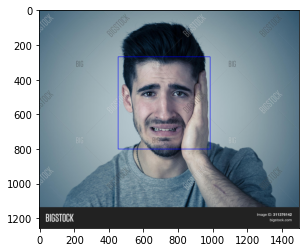

In [5]:
faceCascade = cv2.CascadeClassifier("haarcascade-frontalface-default.xml")
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
frame = cv2.imread("sad2.jpg")
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces = faceCascade.detectMultiScale(gray, 1.1, 4)
for (x, y, w, h) in faces:
    cv2.rectangle(frame, (x,y), (x+w, y+h), (255, 0, 0), 2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print("Face Not Detected")
    else:
        for (ex, ey, ew, eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex + ew]
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [6]:
test = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
final_image = cv2.resize(test, (48,48))
final_image = np.expand_dims(final_image, axis = 0)
final_image = final_image/255.0
prediction = model.predict(final_image)
classes[np.argmax(prediction[0])]

1/1 [==============================] - 7s 7s/step


'sad'

In [9]:
# To capture video from a webcam
cap = cv2.VideoCapture(0)

if not (cap.isOpened()):
    print('Could not open video device')

# Load the cascade
face_cascade = cv2.CascadeClassifier('haarcascade-frontalface-default.xml') 
font = cv2.FONT_HERSHEY_SIMPLEX
# To use a video file as input 
# cap = cv2.VideoCapture('filename.mp4')
counts = {}
while True:
    # Read the frame
    _, frame = cap.read()
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Detect the faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    # Draw the rectangle around each face
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (255, 0, 0), 2)
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(facess) == 0:
            print("Face Not Detected")
        else:
            for (ex, ey, ew, eh) in facess:
                face_roi = roi_color[ey: ey+eh, ex:ex + ew]
        
        final_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        final_image = cv2.resize(final_image, (48,48))
        final_image = np.expand_dims(final_image, axis = 0)
        final_image = final_image / 255.0
        pred = model.predict(final_image)
        rounded_prediction = np.argmax(pred, axis=1)
        emotion = classes[rounded_prediction[0]]
        cv2.putText(frame, str(emotion), (x, y), font, 1, (255, 255, 0), 2)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        
    if cv2.waitKey(1) == 27:
        break
    cv2.imshow('Filter', frame)
    # Stop if escape key is pressed
    k = cv2.waitKey(30) & 0xff
    if k==27:
        break
# Release the VideoCapture object
cap.release()

Face Not Detected
1/1 [==============================] - 0s 245ms/step
Face Not Detected
1/1 [==============================] - 0s 28ms/step
Face Not Detected
1/1 [==============================] - 0s 28ms/step
Face Not Detected
1/1 [==============================] - 0s 27ms/step
Face Not Detected
1/1 [==============================] - 0s 28ms/step
Face Not Detected
1/1 [==============================] - 0s 30ms/step
Face Not Detected
1/1 [==============================] - 0s 27ms/step
Face Not Detected
1/1 [==============================] - 0s 30ms/step
Face Not Detected
1/1 [==============================] - 0s 28ms/step
Face Not Detected
1/1 [==============================] - 0s 28ms/step
Face Not Detected
1/1 [==============================] - 0s 28ms/step
Face Not Detected
1/1 [==============================] - 0s 29ms/step
Face Not Detected
1/1 [==============================] - 0s 29ms/step
Face Not Detected
1/1 [==============================] - 0s 29ms/step
Face Not Detected
1

: 